# Image Extraction for various splits of the DAA Dataset
* There are three splits of the DAA Dataset: Split 0, Split 1, Split 2
* The split 0 annotation file used is : midlevel.chunks_90.split_0.test.csv

In [1]:
!nvidia-smi

Fri Sep  1 22:39:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   68C    P0   295W / 300W |  20035MiB / 32768MiB |     90%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU device:',torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU avaialable, Using CPU')

torch.cuda.set_device(2)

/home/sur06423/miniconda3/envs/vi_trans/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU device: Tesla V100-SXM2-32GB


# Creating Directory Structure for the split 0 daa Dataset
* The camera used for capturing RGB Images is Microsoft Kinect Camera (XBOX One)
* Resolution of the images is 950 x 540 pixel
* FPS = 15 Hz

In [2]:
import os
class_names= ['closing_bottle', 'closing_door_inside', 'closing_door_outside', 'closing_laptop', 'drinking', 'eating', 'entering_car', 'exiting_car', 
                                'fastening_seat_belt', 'fetching_an_object', 'interacting_with_phone', 'looking_or_moving_around (e.g. searching)', 'opening_backpack', 
                                'opening_bottle', 'opening_door_inside', 'opening_door_outside', 'opening_laptop', 'placing_an_object', 'preparing_food', 'pressing_automation_button', 
                                'putting_laptop_into_backpack', 'putting_on_jacket', 'putting_on_sunglasses', 'reading_magazine', 'reading_newspaper', 'sitting_still', 
                                'taking_laptop_from_backpack', 'taking_off_jacket', 'taking_off_sunglasses', 'talking_on_phone', 'unfastening_seat_belt', 'using_multimedia_display', 
                                'working_on_laptop', 'writing']

root_dir_test = '/net/polaris/storage/deeplearning/sur_data/rgb_daa/split_1/test'
root_dir_train = '/net/polaris/storage/deeplearning/sur_data/rgb_daa/split_1/train'
root_dir_val = '/net/polaris/storage/deeplearning/sur_data/rgb_daa/split_1/val'

dir_list = [root_dir_test, root_dir_train,root_dir_val]

for dir_path in dir_list:
# Create the root directory if it doesn't exist
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    # Create subdirectories based on class_names
    for class_name in class_names:
        class_dir = os.path.join(dir_path, class_name)
        os.makedirs(class_dir)

# Class for extracting frames from videos tocreate batches


In [7]:
image_number = 42
formatted_filename = "img_{:05d}.jpg".format(image_number)
print(formatted_filename)
image_number = 44
formatted_filename = f"img_{image_number:05d}.jpg"
print(formatted_filename)



img_00042.jpg
img_00044.jpg


In [9]:
import os
import cv2
import csv

class FrameExtractor:
    def __init__(self, data_dir, output_dir):
        self.data_dir = data_dir
        self.output_dir = output_dir

    def extract_frames(self, row, max_frames_per_chunk):
        participant_id, file_id, annotation_id, frame_start, frame_end, activity, chunk_id = row
        video_filepath = os.path.join(self.data_dir, file_id + '.mp4')
        new_file_id = file_id.replace("/", "_")
        updated_output_dir = os.path.join(self.output_dir, f'{activity}', f'{participant_id}_{new_file_id}_frames_{frame_start}_{frame_end}_ann_{annotation_id}_chunk_{chunk_id}')
        
        os.makedirs(updated_output_dir, exist_ok=True)
        cap = cv2.VideoCapture(video_filepath)
        frame_count = 0
         
        try:
            # Set the starting frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_start))
            
            for frame_num in range(int(frame_start), int(frame_end) + 1):
                ret, frame = cap.read()
                if not ret:
                    print(f"Frame number {frame_num} is missing.")
                    break
                #new_file_id = file_id.replace("/", "_")
                output_filename = f'img_{frame_num:06d}.png'
                output_path = os.path.join(updated_output_dir, output_filename)
                cv2.imwrite(output_path, frame)
                frame_count += 1
                
                if frame_count > max_frames_per_chunk:
                    break
        finally:
            cap.release()

def process_annotations(annotation_file, data_dir, root_dataset_dir, dataset_sub_dir, max_frames_per_chunk=48):
    with open(annotation_file, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row
        output_dir = os.path.join(root_dataset_dir, dataset_sub_dir)
        frame_extractor = FrameExtractor(data_dir, output_dir)
        
        for row in reader:
            frame_extractor.extract_frames(row, max_frames_per_chunk)

def main():
    data_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/data/kinect_color/kinect_color"
    root_dataset_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/daa_dataset"
    dataset_sub_dirs = ['train'] #, 'train', 'test'
    annotation_files = [
        '/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/data/kinect_color_annotation/activities_3s/kinect_color/midlevel.chunks_90.split_0.train.csv'
    ] #,
      #  '/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/data/kinect_color_annotation/activities_3s/kinect_color/midlevel.chunks_90.split_0.train.csv',
      #  '/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/data/kinect_color_annotation/activities_3s/kinect_color/midlevel.chunks_90.split_0.test.csv'
    
    for annotation_file, dataset_sub_dir in zip(annotation_files, dataset_sub_dirs):
        process_annotations(annotation_file, data_dir, root_dataset_dir, dataset_sub_dir)

if __name__ == "__main__":
    main()


The choice between padding with zeros and padding with the last frame depends on the specific characteristics of your dataset and the problem you are trying to solve. Each option has its own advantages and potential trade-offs:

# Padding with Zeros:

* Advantages: Padding with zeros is simple and can work well when the content of the padding frames is not important for your task. It doesn't introduce additional information to the model and maintains consistency in the batch dimensions.

* Trade-offs: If the frames contain meaningful information in the temporal context (e.g., motion or changes between frames), padding with zeros might degrade the model's ability to capture temporal patterns.

# Padding with Last Frame:

* Advantages: Padding with the last frame can help maintain some temporal context, which might be beneficial for tasks that rely on motion or changes between frames. It can help the model better understand the transition from observed frames to padded frames.

* Trade-offs: Padding with the last frame assumes that the last frame is representative of the sequence's continuation, which might not always be accurate. It could introduce some bias in the model's understanding of the padding frames.

# Alternating Padding:

* Option: Another approach could be to alternate between padding with zeros and padding with the last frame, providing a balance between maintaining context and avoiding introducing potentially misleading information.

# Dynamic Padding:

* Option: Instead of padding to a fixed length (e.g., 48 frames), you could dynamically pad sequences to the length of the longest sequence in the batch. This can minimize unnecessary padding and make better use of computational resources.

The best option depends on the nature of your data and the requirements of your specific task. It's often a good practice to experiment with different padding strategies and evaluate their impact on your model's performance. For example, you could train your model using both padding with zeros and padding with the last frame and compare their performance on validation data to determine which approach works better for your use case.

References: 

Deep Learning Book by Ian Goodfellow, Yoshua Bengio, and Aaron Courville:

Chapter 10: Sequence Modeling: https://www.deeplearningbook.org/contents/rnn.html
This book provides a comprehensive overview of sequence modeling and discusses the challenges and considerations related to padding sequences.

PyTorch Documentation - Padding Sequences:

https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html#padding-the-data
While this resource is focused on natural language processing, the concept of padding sequences is applicable to various types of sequence data.
Coursera Deep Learning Specialization - Sequence Models Course:

https://www.coursera.org/specializations/deep-learning
This specialization covers sequence models, including topics like RNNs, LSTMs, and padding strategies. It provides practical insights into handling sequence data.
Neural Machine Translation by Jointly Learning to Align and Translate (Bahdanau et al., 2014):

https://arxiv.org/abs/1409.0473
This paper introduces the concept of attention mechanisms in sequence-to-sequence models, which helps address the padding issue by dynamically weighting different parts of the sequence.
Temporal Relational Reasoning in Videos (Girdhar et al., 2019):

https://arxiv.org/abs/1711.08496
This paper explores the challenges of reasoning over long video sequences and discusses how temporal relations can be captured effectively, which can relate to padding strategies.
Machine Learning Mastery Blog - How to Prepare Time Series Data for LSTM Networks:

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
While focused on time series data, this blog post discusses various aspects of preparing sequence data for LSTM networks, including padding.

In [6]:
root_dataset_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/rgb_midlevel_split_0"
dataset_sub_dirs = ['test', 'train', 'val']
activities = ['closing_bottle', 'closing_door_inside', 'closing_door_outside', 'closing_laptop', 'drinking', 'eating', 'entering_car', 'exiting_car', 
                                'fastening_seat_belt', 'fetching_an_object', 'interacting_with_phone', 'looking_or_moving_around (e.g. searching)', 'opening_backpack', 
                                'opening_bottle', 'opening_door_inside', 'opening_door_outside', 'opening_laptop', 'placing_an_object', 'preparing_food', 'pressing_automation_button', 
                                'putting_laptop_into_backpack', 'putting_on_jacket', 'putting_on_sunglasses', 'reading_magazine', 'reading_newspaper', 'sitting_still', 
                                'taking_laptop_from_backpack', 'taking_off_jacket', 'taking_off_sunglasses', 'talking_on_phone', 'unfastening_seat_belt', 'using_multimedia_display', 
                                'working_on_laptop', 'writing']

In [10]:
root_dataset_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/rgb_midlevel_split_0"
dataset_sub_dirs = 'test'
activities = ['closing_bottle']

for activity in activities:
    activity_dir = os.path.join(root_dataset_dir, dataset_sub_dirs, activity)
    if os.path.exists(activity_dir):
        for annotation_id in os.listdir(activity_dir):
            annotation_dir = os.path.join(activity_dir, annotation_id)
            for chunk_id in os.listdir(annotation_dir):
                chunk_dir = os.path.join(annotation_dir, chunk_id)
                print(f" the annotation_dir is {chunk_dir}")


 the annotation_dir is /home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/rgb_midlevel_split_0/test/closing_bottle/annotaion_id_36/chunk_0
 the annotation_dir is /home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/rgb_midlevel_split_0/test/closing_bottle/annotaion_id_36/chunk_1
 the annotation_dir is /home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/rgb_midlevel_split_0/test/closing_bottle/annotaion_id_73/chunk_0
 the annotation_dir is /home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/rgb_midlevel_split_0/test/closing_bottle/annotaion_id_80/chunk_0
 the annotation_dir is /home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/rgb_midlevel_split_0/test/closing_bottle/annotaion_id_45/chunk_0
 the annotation_dir is /home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/rgb_midlevel_split_0/test/closing_bottle/annotaion_id_48/chunk_0
 the annotation_dir is /home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/rgb_midlevel_split_0/test/closing_bottle/annotaion_id_48/chunk_1

In [5]:
import os
root_dataset_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/rgb_midlevel_split_0"
dataset_sub_dirs = ['test', 'train', 'val']
activities = ['closing_bottle', 'closing_door_inside', 'closing_door_outside', 'closing_laptop', 'drinking', 'eating', 'entering_car', 'exiting_car', 
                                'fastening_seat_belt', 'fetching_an_object', 'interacting_with_phone', 'looking_or_moving_around (e.g. searching)', 'opening_backpack', 
                                'opening_bottle', 'opening_door_inside', 'opening_door_outside', 'opening_laptop', 'placing_an_object', 'preparing_food', 'pressing_automation_button', 
                                'putting_laptop_into_backpack', 'putting_on_jacket', 'putting_on_sunglasses', 'reading_magazine', 'reading_newspaper', 'sitting_still', 
                                'taking_laptop_from_backpack', 'taking_off_jacket', 'taking_off_sunglasses', 'talking_on_phone', 'unfastening_seat_belt', 'using_multimedia_display', 
                                'working_on_laptop', 'writing']

data = []

for dataset_sub_dir in dataset_sub_dirs:
    for activity in activities:
        activity_dir = os.path.join(root_dataset_dir, dataset_sub_dir, activity)
        if os.path.exists(activity_dir):
            for annotation_id in os.listdir(activity_dir):
                    annotation_dir = os.path.join(activity_dir, annotation_id)
                    for chunk_id in os.listdir(annotation_dir):
                        chunk_dir = os.path.join(annotation_dir, chunk_id)
                        data.append(chunk_dir)

In [13]:
data[1]

'/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/rgb_midlevel_split_0/test/closing_bottle/annotaion_id_36/chunk_1'

# The Number of chunks in train dataset of split o of midlevel90 are 8171

In [7]:
len(data)

8171

In [3]:
import os
import torch
import cv2
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


# The size of image : Image at index 0 has size: 960 x 540 with 3 channels

In [35]:
def read_frames_from_directory(directory, max_frames=45):
    frames = []
    frame_count = 0  # Initialize a counter
    
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            frame_path = os.path.join(directory, filename)
            frame = cv2.imread(frame_path)
            frames.append(frame)
            frame_count += 1
            
            if frame_count >= max_frames:
                break  # Stop adding frames once the maximum is reached
    
    return frames

# Example usage
idx = 0
frames = read_frames_from_directory(data[idx])

# Print the number of frames read (up to a maximum of 45)
print(f"Number of frames read: {len(frames)}")

image = frames[idx]
height, width, channels = image.shape
print(f"Image at index {idx} has size: {width} x {height} with {channels} channels")



Number of frames read: 45
Image at index 0 has size: 960 x 540 with 3 channels


The Total number of frames stored in the frames list are 45


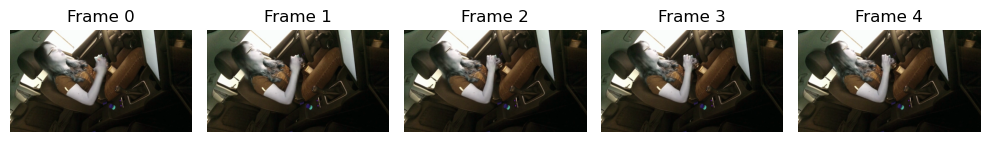

In [34]:
import matplotlib.pyplot as plt

def plot_frames(frames, start_idx=0, num_frames=None, figsize=(10, 8)):
    if num_frames is None:
        num_frames = len(frames) - start_idx
    
    fig, axes = plt.subplots(1, num_frames, figsize=figsize)
    
    for i in range(num_frames):
        ax = axes[i] if num_frames > 1 else axes
        ax.imshow(frames[start_idx + i])
        ax.axis('off')
        ax.set_title(f'Frame {start_idx + i}')

    plt.tight_layout()
    plt.show()


idx = 0
frames = read_frames_from_directory(data[idx])
print(f"The Total number of frames stored in the frames list are {len(frames)}")
plot_frames(frames, start_idx=0, num_frames=5)


In [ ]:
idx = 0  # Choose the index of the image you want to check
image = frames[idx]
height, width, channels = image.shape
print(f"Image at index {idx} has size: {width} x {height} with {channels} channels")


In [4]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

# Use this function to add files to the dataset and then create a simple dataloader

In [7]:
import os
import shutil
from PIL import Image

target_directory = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/test_img"


def complete_image_count(target_directory):
    try:
        # Navigate to the target directory
        os.chdir(target_directory)

        # Get a list of all .png files in the directory
        png_files = [file for file in os.listdir() if file.lower().endswith('.png')]

        # Count the number of .png files
        png_count = len(png_files)

        if png_count >= 50:
            print("Image count is already 48 or more.")
        else:
            # Get the shape of the first image in the directory
            first_image_path = os.path.join(target_directory, png_files[0])
            first_image = Image.open(first_image_path)
            image_shape = first_image.size
            print(f"The image shape is {image_shape}")

            # Calculate the number of images needed to reach 48
            remaining_images = 50 - png_count

            # Create new images with zeros and the same shape as the first image
            for i in range(remaining_images):
                new_image = Image.new('RGB', image_shape, (0, 0, 0))
                new_image_path = os.path.join(target_directory, f'zero_image_{i}.png')
                new_image.save(new_image_path)
                print(f"Created {new_image_path}")

            print(f"Total images in the directory: {png_count + remaining_images}")

    except Exception as e:
        print(f"An error occurred: {e}")

complete_image_count(target_directory)

The image shape is (960, 540)
Created /home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/test_img/zero_image_0.png
Created /home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/test_img/zero_image_1.png
Total images in the directory: 50


In [ ]:
import os
import csv

def count_and_create_csv(directory_path):
    # Initialize counters and calculate the number of remaining images
    image_count = 0
    remaining_images = 0
    
    # Count the number of .png images in the directory
    for filename in os.listdir(directory_path):
        if filename.lower().endswith(".png"):
            image_count += 1
    
    # Determine the appropriate remaining images value based on the image count
    if image_count <= 16:
        remaining_images = 16 - image_count
    elif image_count <= 32:
        remaining_images = 32 - image_count
    elif image_count <= 48:
        remaining_images = 48 - image_count
    
    # Create a CSV file and write the data
    csv_filename = os.path.join(directory_path, "csv_file_01.csv")
    with open(csv_filename, "w", newline="") as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(["Path", "Image Count", "Remaining Images"])
        csv_writer.writerow([directory_path, image_count, remaining_images])
    
    print(f"CSV file '{csv_filename}' created successfully.")

# Call the function with the directory path you want to process
directory_path = "path/to/your/directory"
count_and_create_csv(directory_path)


In [ ]:
import os
import csv

def process_directories(root_directory, paths_list):
    # Create the CSV file in the root directory
    csv_filename = os.path.join(root_directory, "csv_file_01.csv")
    
    with open(csv_filename, "w", newline="") as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(["Path", "Image Count", "Remaining Images"])
        
        for path in paths_list:
            image_count = 0
            remaining_images = 0
            
            # Count the number of .png images in the current directory
            for filename in os.listdir(path):
                if filename.lower().endswith(".png"):
                    image_count += 1
            
            # Determine the appropriate remaining images value based on the image count
            if image_count <= 16:
                remaining_images = 16 - image_count
            elif image_count <= 32:
                remaining_images = 32 - image_count
            elif image_count <= 48:
                remaining_images = 48 - image_count
            
            # Write data for the current path to the CSV file
            csv_writer.writerow([path, image_count, remaining_images])
    
    print(f"CSV file '{csv_filename}' created successfully.")

# Example usage
root_directory = "path/to/root/directory"
paths_list = ["path/to/dir1", "path/to/dir2", "path/to/dir3"]  # Add your list of directory paths
process_directories(root_directory, paths_list)


In [14]:
import torch
from torchvision.io import read_image
im = read_image("/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/test_img/vp11_run2_2018-05-24-14-35-56.kinect_color_3277.png")
image = Image.open("/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/test_img/zero_image_0.png")
im2 = read_image("/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/test_img/zero_image_0.png")

print(f"The im size is {im.shape}")
print(f"The image size is {image.size}")
im2.shape


The im size is torch.Size([3, 540, 960])
The image size is (960, 540)


torch.Size([3, 540, 960])

In [ ]:
import os
import torch
from torchvision.io import read_image

def process_frames(directory_path, maximum_frames=45):
    # List to store one split
    split = []
    
    # Get a list of frame filenames in the directory
    frame_files = sorted([f for f in os.listdir(directory_path) if f.endswith('.png')])
    
    for idx, frame_file in enumerate(frame_files):
        if idx < 48:
            split.append(frame_file)
        else:
            pass
    
    # Create tensors 
    result_tensor = []
    for frame_file in split:
        frame_path = os.path.join(directory_path, frame_file)
        frame_tensor = read_image(frame_path)
        result_tensor.append(frame_tensor)

    batch_tensor = torch.stack(result_tensor)

    # Create batches of 16 images each
    batch_size = 16
    print(f"The batch_tensor.size(0) is {batch_tensor.size(0)}")
    num_batches = batch_tensor.size(0) // batch_size
    print(f"The num_batches is {num_batches}")
    batches = [batch_tensor[i * batch_size: (i + 1) * batch_size] for i in range(num_batches)]

    # If there are remaining images, create a last batch with zero-padding
    remaining_images = batch_tensor.size(0) % batch_size
    print(f"The remaining_images are {remaining_images}")
    #if remaining_images > 0:
    #    last_batch = batch_tensor[-remaining_images:]
    #    padding = torch.zeros(batch_size - remaining_images, *last_batch.size()[1:])
    #    last_batch = torch.cat((last_batch, padding), dim=0)
    #    batches.append(last_batch)

    # Convert the batches list to a single tensor
    #batches_tensor = torch.stack(batches, dim=0)

    return batches

# Example usage
directory_path = '/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/test_img'
maximum_frames = 45
tensor_splits = process_frames(directory_path, maximum_frames)
print(tensor_splits.shape)

In [2]:
import torch
import numpy as np

def custom_collate_fn(batch_tensor):
    # Convert the batch list of tensors to a single tensor
    #batch_tensor = torch.stack(batch, dim=0)

    # Create batches of 16 images each
    batch_size = 16
    print(f"The batch_tensor.size(0) is {batch_tensor.size(0)}")
    num_batches = batch_tensor.size(0) // batch_size
    print(f"The num_batches is {num_batches}")
    batches = [batch_tensor[i * batch_size: (i + 1) * batch_size] for i in range(num_batches)]

    # If there are remaining images, create a last batch with zero-padding
    remaining_images = batch_tensor.size(0) % batch_size
    print(f"The remaining_images are {remaining_images}")
    if remaining_images > 0:
        last_batch = batch_tensor[-remaining_images:]
        padding = torch.zeros(batch_size - remaining_images, *last_batch.size()[1:])
        last_batch = torch.cat((last_batch, padding), dim=0)
        batches.append(last_batch)

    # Convert the batches list to a single tensor
    batches_tensor = torch.stack(batches, dim=0)

    return batches_tensor


In [3]:
batch = tensor_splits
padded_batch_1 = custom_collate_fn(batch)
padded_batch_1.shape

The batch_tensor.size(0) is 44
The num_batches is 2
The remaining_images are 12


torch.Size([3, 16, 3, 540, 960])